In [1]:
# !pip install sbi

import torch
import numpy as np
from scipy.signal import welch
from sbi import utils as sbi_utils
from sbi.inference import SNPE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import load_model

In [ ]:


#  Load Trained Generator
generator = load_model("saved_models/qpo_cgan_phy_generator.keras")

# --- Hyperparameters ---
latent_dim = 100
num_simulations = 10000

#  Prior: fc ∈ [0.01, 1.0], amp ∈ [0.1, 1.0]
prior = sbi_utils.BoxUniform(low=torch.tensor(
    [0.01, 0.1]), high=torch.tensor([1.0, 1.0]))

#  GAN-based simulator for SBI


def simulator(theta):
    fc, amp = theta.numpy()
    z = torch.randn((1, latent_dim))
    label = torch.tensor([[fc, amp, 1.0]], dtype=torch.float32)  # force QPO
    generated = generator([z, label], training=False).numpy().squeeze()
    f, Pxx = welch(generated, fs=1, nperseg=256)
    return torch.tensor(Pxx, dtype=torch.float32)


# --- Generate Simulations
print("Generating synthetic QPOs for SBI...")
thetas = prior.sample((num_simulations,))
xs = torch.stack([simulator(theta) for theta in thetas])

# --- Train SBI Posterior
inference = SNPE(prior)
density_estimator = inference.append_simulations(thetas, xs).train()
posterior = inference.build_posterior(density_estimator)

#  Save Trained Posterior
torch.save(posterior, "saved_models/trained_sbi_posterior.pt")
print(" SBI Posterior trained and saved.")

Generating synthetic QPOs for SBI...
 Neural network successfully converged after 52 epochs.✅ SBI Posterior trained and saved.


/var/folders/15/7vdcd9756072lbp614rqt18c0000gn/T/ipykernel_72645/1754957020.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior = torch.load("trained_sbi_posterior

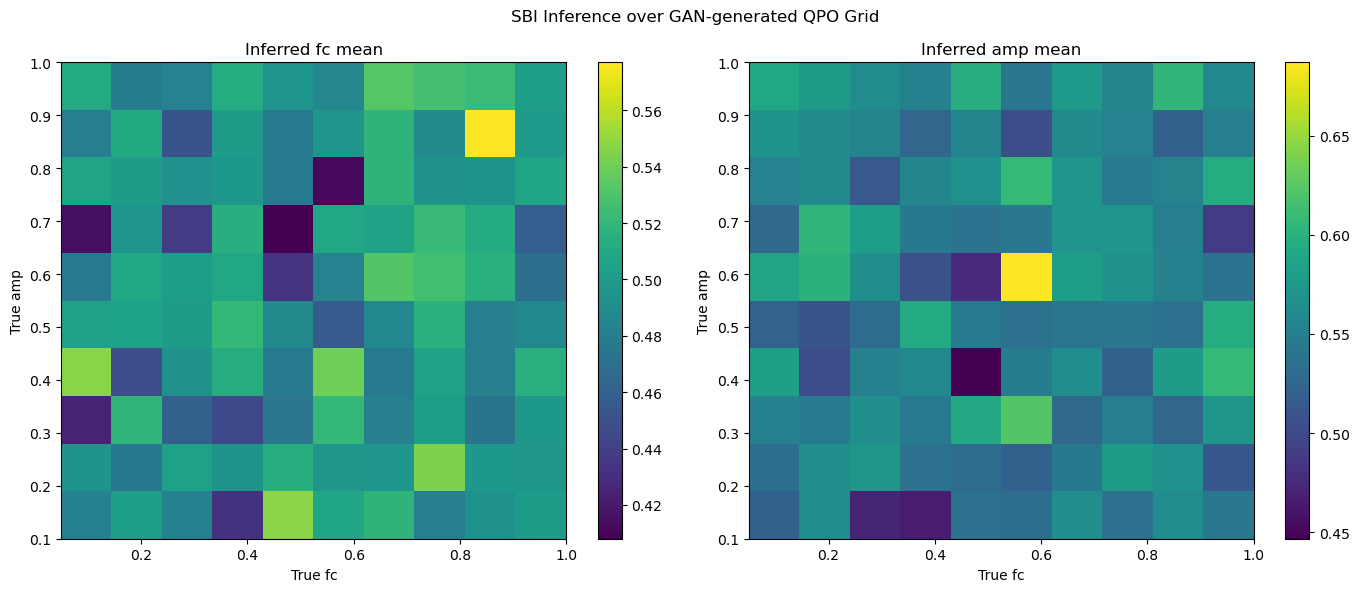

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.signal import welch

# Load posterior (already trained and saved)
posterior = torch.load("saved_models/trained_sbi_posterior.pt")

# Load generator
from tensorflow.keras.models import load_model
generator = load_model("saved_models/qpo_cgan_phy_generator.keras")

# --- Grid settings ---
fc_values = np.linspace(0.05, 1.0, 10)
amp_values = np.linspace(0.1, 1.0, 10)

# Store inferred fc and amp
inferred_fc = np.zeros((len(amp_values), len(fc_values)))
inferred_amp = np.zeros_like(inferred_fc)

latent_dim = 100

# --- Run inference on each (fc, amp) pair ---
for i, amp in enumerate(amp_values):
    for j, fc in enumerate(fc_values):
        label = torch.tensor([[fc, amp, 1.0]], dtype=torch.float32)
        z = torch.randn((1, latent_dim))
        generated = generator([z, label], training=False).numpy().squeeze()

        # Compute PSD
        f, Pxx = welch(generated, fs=1, nperseg=256)
        x_obs = torch.tensor(Pxx, dtype=torch.float32)

        # Posterior inference
        samples = posterior.sample((500,), x=x_obs, show_progress_bars=False)
        inferred_fc[i, j] = samples[:, 0].mean().item()
        inferred_amp[i, j] = samples[:, 1].mean().item()

# --- Plot Heatmaps ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im1 = axes[0].imshow(inferred_fc, origin='lower', extent=[0.05, 1.0, 0.1, 1.0], aspect='auto')
axes[0].set_title("Inferred fc mean")
axes[0].set_xlabel("True fc")
axes[0].set_ylabel("True amp")
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(inferred_amp, origin='lower', extent=[0.05, 1.0, 0.1, 1.0], aspect='auto')
axes[1].set_title("Inferred amp mean")
axes[1].set_xlabel("True fc")
axes[1].set_ylabel("True amp")
fig.colorbar(im2, ax=axes[1])

plt.suptitle("SBI Inference over GAN-generated QPO Grid")
plt.tight_layout()
plt.show()
